<a href="https://colab.research.google.com/github/juansolana/edinquake/blob/master/pkw_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd

In [0]:
def plot_common(array, start=0, end=None, step=1, xlabel="", ylabel="", title=""):
  if array is None:
    print("array should not be none")
    return
  if end is None:
    end = array.shape[0]
  
  fig = plt.figure(figsize=(16,7))
  ax = fig.add_subplot(111)
  ax.plot(np.arange(start, end, step), array[start:end:step])
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  
  
def sns_plot(array, start=0, end=None, step=1, xlabel="index", ylabel="", title=""):
  if array is None:
    print("array should not be none")
    return
  if end is None:
    end = len(array)

  fig, ax1 = plt.subplots(figsize=(16, 6))
  fig.suptitle(title, fontsize=14)

  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(ylabel)
  p1 = sns.lineplot(data=array)
  
def sns_plot_data_frame_column(data_frame, column_name, start=0, end=None, step=1, xlabel="index", ylabel="", title=""):
  arr = data_frame.iloc[start:end:step].acoustic_data.values
  sns_plot(arr, start, end, step, xlabel, ylabel, title)
  
def sns_plot_data_frame(data_frame, start=0, end=None, step=1, xlabel="index", ylabel1="", ylabel2""):
  

(999, 2)


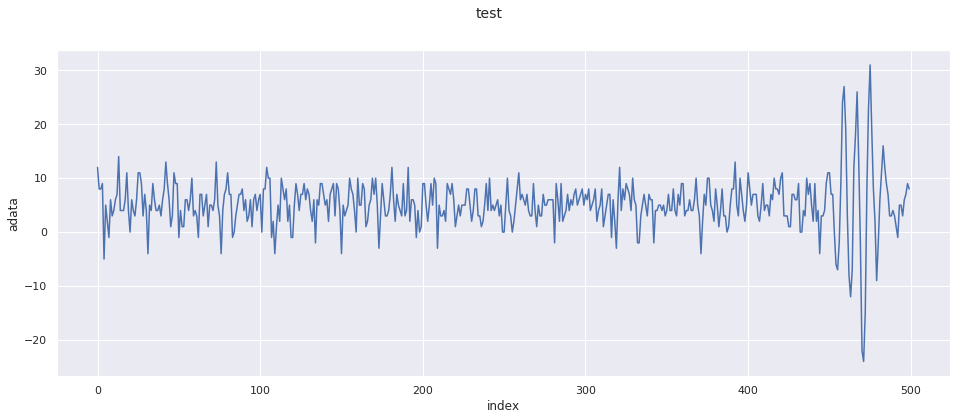

In [0]:
tmp_csv = pd.read_csv('tmp.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(tmp_csv.shape)
sns_plot_data_frame_column(tmp_csv, 'acoustic_data', step=2, title='test', ylabel='adata')
#arr = np.asarray([1,2,13,42,54,6,7,8,11,43,65,1,3,7,4,5,2,76,12,87,32])
#plot_common(arr, start=2, end=15, step=2, xlabel='trytry', ylabel='yyy')

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import numpy as np

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.103.26.170:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 11592956586587472035),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3209528423454898235),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11532780780740645179),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2819465849502304156),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7094915971368290947),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13153420586784176307),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9486716581397585706),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 15575959019059172685),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 164

In [0]:
MODEL = 'BASIC_LSTM' #@param {type:"string"}
BUCKET = 'edinquake_pkw' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'

DATA_DIR = 'gs://{}/data'.format(BUCKET)
print('***** Data directory: {} *****'.format(DATA_DIR))
!gsutil ls $DATA_DIR


#OUTPUT_DIR = 'gs://{}/models/{}/'.format(BUCKET, MODEL)
#tf.gfile.MakeDirs(OUTPUT_DIR)
#print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Data directory: gs://edinquake_pkw/data *****
gs://edinquake_pkw/data/
gs://edinquake_pkw/data/quakes.txt
gs://edinquake_pkw/data/quakes_128
gs://edinquake_pkw/data/quakes_128_new
gs://edinquake_pkw/data/train.csv
gs://edinquake_pkw/data/test/


In [0]:
def split_convert(s):
  splitted = s.split(',')
  signal = float(splitted[0])
  time = float(splitted[1])
  return [signal, time]

def to_int_str(n):
  return str(int(n))

def to_str(n):
  return str(n)

def list_to_str(working_list, input_size, padding=True):
  write_str = ""
  working_list_len = len(working_list)
  working_list = list(map(split_convert, working_list))
  
  if padding is True:
    pad_size = (input_size - (working_list_len % input_size)) % input_size
    edge_ele = working_list[-1]
    working_list += [edge_ele] * pad_size
    working_list_len = len(working_list)
  
  working_list = np.asarray(working_list)
  chunk_num = working_list_len // input_size
  chunked_arr = np.split(working_list, chunk_num)
  chunked_arr = np.asarray(chunked_arr)
  transposed = np.transpose(chunked_arr, (0,2,1))
  working_list = (transposed).tolist()
  for row in working_list:
    signals, times = row
    signals = list(map(to_int_str, signals))
    times = list(map(to_str, times))
    sig_str = ",".join(signals)
    time_str = ",".join(times)
    row_str = sig_str + "\t" + time_str + "\n"
    unrow = row_str.split(',')
    write_str += row_str
    #print('write_str split: {}'.format(len(write_str.split(','))))
  return write_str
    
import time
def read_convert_raw_train_csv(reader, input_size, read_chunk_size, writer):
  remaining_list = []
  file_size = reader.size()
  reader.readline() # first line is title
  while (reader.tell() < file_size):
    print('reader pos:{}'.format(reader.tell()))
    start_t = time.time()
    s = reader.read(read_chunk_size)
    end_t = time.time()
    print('time to read {}s'.format(end_t - start_t))

    remain = ""
    curr_char = reader.read(1)
    while (curr_char != '\n'):
      remain += curr_char
      curr_char = reader.read(1)
      if reader.tell() == file_size:
        break

    s += remain
    str_list = s.split('\n')
    remaining_list += str_list
    row_count = len(remaining_list)
    if row_count < input_size:
      continue
    nearest_input_size_multiple = (row_count // input_size) * input_size
    print('nearest: {}'.format(nearest_input_size_multiple))
    working_list = remaining_list[:nearest_input_size_multiple]
    remaining_list = remaining_list[nearest_input_size_multiple:]
    #print('working: {}'.format(working_list))
    #print('remaining: {}'.format(remaining_list))
    
    print('start list to str')
    write_str = list_to_str(working_list, input_size, False)
    start_t = time.time()
    print('start writing...')
    writer.write(write_str)
    writer.flush()
    end_t = time.time()
    print('time to write {}s'.format(end_t - start_t))
  
  print('start list to str')
  write_str = list_to_str(working_list, input_size, False)
  #print('final: ' + write_str)
  start_t = time.time()
  print('start writing...')
  writer.write(write_str)
  writer.flush()
  writer.close()
  end_t = time.time()
  print('time to write {}s'.format(end_t - start_t))


In [0]:
# test_reader = tf.gfile.GFile(DATA_DIR + '/test/seg_00030f.csv', "r")
# reader.readline()
# s = test_reader.read(4096)
# file_size = test_reader.size()
# while test_reader.tell() < file_size:
#   print('pos: {}'.format(test_reader.tell()))
#   test_reader.read(1024)
# curr_pos = test_reader.tell()
# print('curr pos: {}'.format(curr_pos))
# test_reader.read(1)
# after_pos = test_reader.tell()
# print('after read one pos: {}'.format(after_pos))
# print('is same: {}'.format(curr_pos == after_pos))

In [0]:
read_chunk_size = 400 * 1024 * 1024 # 400MB
input_size = 128
reader = tf.gfile.GFile(DATA_DIR + '/train.csv', "r")
writer = tf.gfile.GFile(DATA_DIR + '/quakes_{}_real'.format(input_size), "w")
read_convert_raw_train_csv(reader, input_size, read_chunk_size, writer)


reader pos:30
time to read 4.57399845123291s
nearest: 27557376
start list to str
start writing...
time to write 7.063354730606079s
reader pos:419430443
time to read 3.6945645809173584s
nearest: 27485952
start list to str
start writing...
time to write 12.92895793914795s
reader pos:838860848
time to read 4.1693971157073975s
nearest: 27832320
start list to str
start writing...
time to write 18.379984140396118s
reader pos:1258291256
time to read 3.5380914211273193s
nearest: 27467008
start list to str
start writing...
time to write 22.825926303863525s
reader pos:1677721665
time to read 3.1316773891448975s
nearest: 27571968
start list to str
start writing...
time to write 24.434353590011597s
reader pos:2097152069
time to read 3.1148083209991455s
nearest: 27785472
start list to str
start writing...
time to write 26.771021366119385s
reader pos:2516582481
time to read 4.010611295700073s
nearest: 27458176
start list to str
start writing...
time to write 33.00866436958313s
reader pos:2936012892
